### VAR forecasting practice using 2 variables from our own data
#### 2016 data only

**Datasets used**
- Météo 2016 extracted by Aysun, from Google Drive 
    https://drive.google.com/open?id=1WL8lcdSmAXrZ0XcQLkjwJeJA5nctzQ5Z
- Nuitées dans l'hôtellerie - Total - Pays de la Loire (2016)
    https://www.insee.fr/fr/statistiques/serie/001711049 


### #1: Importing libraries

In [1]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline

### #2: Cleaning datasets

In [2]:
# Importing Hotel nights dataset, removing useless rows/columns, and renaming columns 

data_nights = pd.read_csv('datasets/valeurs_mensuelles.csv', sep=";")
#data_nights.isnull().sum()
data_nights.dropna(inplace=True)
data_nights.head()
data_nights = data_nights.rename(columns={'Libellé': 'Date', 
                                          "Nuitées dans l'hôtellerie - Total - Pays de la Loire": "Nights"})
data_nights.head()
data_nights.drop("Codes", axis=1, inplace=True)
data_nights.head()

,Date,Nights
2,2017-01,388.64
3,2016-12,407.55
4,2016-11,463.79
5,2016-10,575.70
6,2016-09,677.11


In [3]:
# Hotel nights data set
# Changing Date to date format, setting Date column as index and reordering dates in ascending order

data_nights['Date'] = pd.to_datetime(data_nights.Date)
data_nights.info()
data_nights = data_nights.set_index('Date')

data_nights = data_nights.sort_values(by='Date')
# data_nights = data_nights[:-1] 
    # Dropped row from 2017
data_nights


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 2 to 14
Data columns (total 2 columns):
Date      13 non-null datetime64[ns]
Nights    13 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 312.0 bytes


,Nights
Date,
2016-01-01,369.21
2016-02-01,411.32
2016-03-01,509.15
2016-04-01,580.11
2016-05-01,645.10
2016-06-01,715.97
2016-07-01,825.06
2016-08-01,872.86
2016-09-01,677.11


In [4]:
# Importing Meteo monthly weather dataset, removing useless rows/columns, and renaming columns 

data_weather_raw = pd.read_csv('datasets/meteo_2016_2017.csv')
print(data_weather_raw.region.unique())
data_weather = data_weather_raw[['year', 'month', 'region', 'Température moyenne']]
data_weather.head()
# data_weather.isnull().sum()

data_weather = data_weather.rename(columns={'Température moyenne': 'AvgTemp'})
data_weather['AvgTemp'] = data_weather['AvgTemp'].map(lambda x: x.rstrip('°'))
data_weather.head()

data_weather = data_weather[data_weather["region"] == 'pays-de-la-loire']
data_weather = data_weather[data_weather['year'] == 2016]
data_weather

['alsace' 'aquitaine' 'ardeche' 'auvergne' 'bourgogne' 'bretagne' 'centre'
 'champagne-ardenne' 'corse' 'franche-comte' 'ile-de-re' 'ile-de-france'
 'languedoc-roussillon' 'limousin' 'lorraine' 'midi-pyrenees'
 'nord-pas-de-calais' 'normandie' 'pays-de-la-loire' 'picardie'
 'poitou-charentes' 'provence-alpes-c-te-d-azur' 'rh-ne-alpes']


,year,month,region,AvgTemp
216,2016,janvier,pays-de-la-loire,9
217,2016,février,pays-de-la-loire,9
218,2016,mars,pays-de-la-loire,10
219,2016,avril,pays-de-la-loire,12
220,2016,mai,pays-de-la-loire,16
221,2016,juin,pays-de-la-loire,19
222,2016,juillet,pays-de-la-loire,21
223,2016,aout,pays-de-la-loire,23
224,2016,septembre,pays-de-la-loire,21
225,2016,octobre,pays-de-la-loire,14


In [5]:
# Converting year and month columns to same format as date in Hotel nights

# Dict to map FR month names to month number and convert month name to number
month_format = dict(zip(data_weather.month, range(1,13)))
month_format

data_weather['month'] = data_weather['month'].apply(lambda x: month_format[x])
data_weather

# Adding day column for the first of each month so we can convert YYYY/MM/DD with pd.to_datetime below
data_weather['day'] = 1
data_weather = data_weather[['year', 'month', 'day', 'region', 'AvgTemp']]
data_weather

# Combining and converting dates to single column in format datetime
data_weather = data_weather.assign(date=pd.to_datetime(data_weather[['year', 'month', 'day']]))

data_weather_clean = data_weather[['date', 'region', 'AvgTemp']]
data_weather_clean

# Setting Date column as index and reordering dates in ascending order
data_weather_clean.info()
data_weather_clean = data_weather_clean.set_index('date')

data_weather_clean = data_weather_clean.sort_values(by='date')

#drop region name column to perform time series forecasting later
data_weather_clean = data_weather_clean.drop("region", axis=1) 
data_weather_clean.AvgTemp = data_weather_clean.AvgTemp.astype('float64')
data_weather_clean

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 216 to 227
Data columns (total 3 columns):
date       12 non-null datetime64[ns]
region     12 non-null object
AvgTemp    12 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 384.0+ bytes


,AvgTemp
date,
2016-01-01,9.0
2016-02-01,9.0
2016-03-01,10.0
2016-04-01,12.0
2016-05-01,16.0
2016-06-01,19.0
2016-07-01,21.0
2016-08-01,23.0
2016-09-01,21.0


In [14]:
# List of days off in the year in France (applies to this region)

from workalendar.europe import France
from calendar import monthrange

cal = France()

def daysoff(y,m):
    nbdays = monthrange(y, m)[1]
    return(nbdays - cal.get_working_days_delta(datetime.date(y, m, 1), datetime.date(y, m, nbdays)))

# Manually change range of years you want to calculate for here
dict_daysoff = {datetime.date(y, m, 1): daysoff(y,m) for y in range(2016,2017) for m in range(1,13)}
dict_daysoff

daysoff_series = pd.Series(dict_daysoff)
daysoff_series

daysoff_df = daysoff_series.to_frame()
daysoff_df.columns = ['NbDaysOff']
daysoff_df

,NbDaysOff
2016-01-01,11
2016-02-01,9
2016-03-01,10
2016-04-01,10
2016-05-01,11
2016-06-01,9
2016-07-01,12
2016-08-01,10
2016-09-01,9
2016-10-01,10


#### #2a: Checking for correlation

Hotel nights vs. Weather:
Nights    0.95659
dtype: float64
---
Hotel nights vs. Days off:
Nights    0.166919
dtype: float64
---


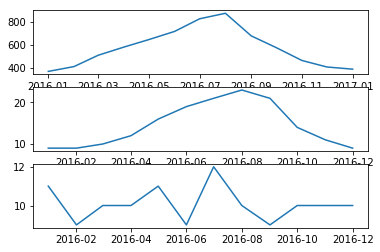

In [26]:
# Check if there's a correlation between Average Temperature and Number of nights
print('Hotel nights vs. Weather:')
print(data_nights.corrwith(data_weather_clean.AvgTemp))
print('---')

print('Hotel nights vs. Days off:')
print(data_nights.corrwith(daysoff_df.NbDaysOff))
print('---')

plt.subplot(3,1,1)
plt.plot(data_nights)
plt.subplot(3,1,2)
plt.plot(data_weather_clean)
plt.subplot(3,1,3)
plt.plot(daysoff_df)


#### #2b: Putting all data into a single dataframe

In [32]:
data = pd.concat([data_nights['Nights'], data_weather_clean['AvgTemp']], axis=1, keys=['Nights', 'AvgTemp'])

,Nights,AvgTemp
2016-01-01,369.21,9.0
2016-02-01,411.32,9.0
2016-03-01,509.15,10.0
2016-04-01,580.11,12.0
2016-05-01,645.10,16.0
2016-06-01,715.97,19.0
2016-07-01,825.06,21.0
2016-08-01,872.86,23.0
2016-09-01,677.11,21.0
2016-10-01,575.70,14.0


In [35]:
data['NbDaysOff'] = daysoff_df.NbDaysOff
# data = data[:-1] 
data

/Users/jinny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Nights,AvgTemp,NbDaysOff
2016-01-01,369.21,9.0,11
2016-02-01,411.32,9.0,9
2016-03-01,509.15,10.0,10
2016-04-01,580.11,12.0,10
2016-05-01,645.10,16.0,11
2016-06-01,715.97,19.0,9
2016-07-01,825.06,21.0,12
2016-08-01,872.86,23.0,10
2016-09-01,677.11,21.0,9
2016-10-01,575.70,14.0,10


In [36]:
data1 = np.log(data).diff().dropna()
data1

,Nights,AvgTemp,NbDaysOff
2016-02-01,0.108006,0.000000,-0.200671
2016-03-01,0.213371,0.105361,0.105361
2016-04-01,0.130475,0.182322,0.000000
2016-05-01,0.106188,0.287682,0.095310
2016-06-01,0.104233,0.171850,-0.200671
2016-07-01,0.141818,0.100083,0.287682
2016-08-01,0.056319,0.090972,-0.182322
2016-09-01,-0.253941,-0.090972,-0.105361
2016-10-01,-0.162247,-0.405465,0.105361
2016-11-01,-0.216155,-0.241162,0.000000


### #3: Running VAR
According to http://www.statsmodels.org/stable/vector_ar.html#var

In [50]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR

model = VAR(data)

results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Aug, 2018
Time:                     23:44:32
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    5.70580
Nobs:                     10.0000    HQIC:                   4.37330
Log likelihood:          -46.9200    FPE:                    434.489
AIC:                      5.07037    Det(Omega_mle):         88.4366
--------------------------------------------------------------------
Results for equation Nights
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const             1163.264428       550.721302            2.112           0.035
L1.Nights            0.335944         0.638843            0.526           0.599
L1.AvgTemp          54.171943        24.192221            2.239

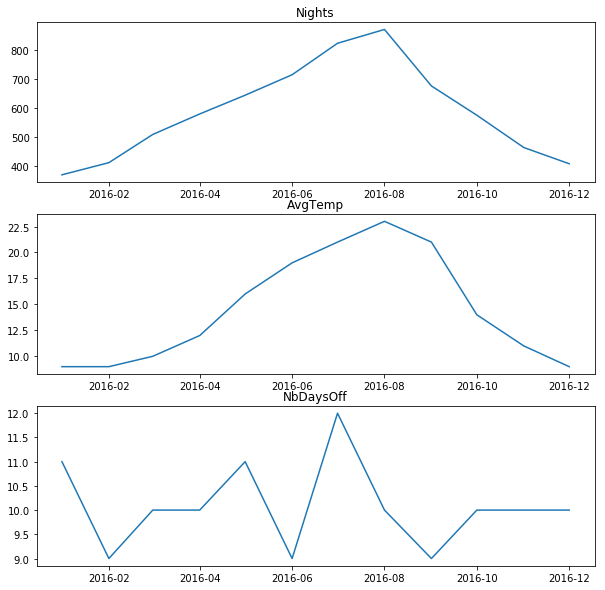

In [39]:
results.plot();

### #4: Forecasted values for the next 12 months

[[421.02843894   8.56734403   9.396565  ]
 [498.65546409   9.9923319   10.36027326]
 [605.95297887  13.46848683  10.22259882]
 [679.90659062  17.03386869  10.16255138]
 [748.71838491  19.03611239  10.29260677]
 [758.52835066  20.00596586  10.28353548]
 [709.05802666  19.25060755   9.9828994 ]
 [635.78557342  16.82496236   9.90465161]
 [560.2166215   14.0507895    9.88899381]
 [497.38564694  11.85406057   9.79656073]
 [474.84665728  10.60403535   9.83786693]
 [497.98261032  10.78929587   9.98950476]]
            Nights  AvgTemp  NbDaysOff
2016-01-01  369.21      9.0         11
2016-02-01  411.32      9.0          9
2016-03-01  509.15     10.0         10
2016-04-01  580.11     12.0         10
2016-05-01  645.10     16.0         11
2016-06-01  715.97     19.0          9
2016-07-01  825.06     21.0         12
2016-08-01  872.86     23.0         10
2016-09-01  677.11     21.0          9
2016-10-01  575.70     14.0         10
2016-11-01  463.79     11.0         10
2016-12-01  407.55      9.0

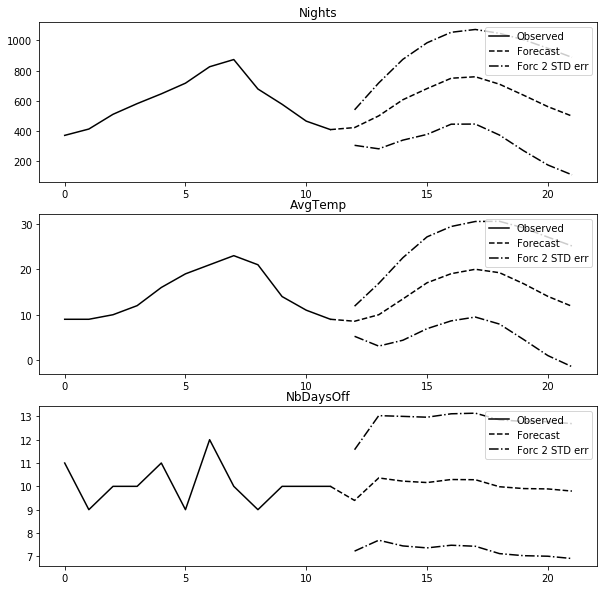

In [54]:
from statsmodels.tsa.api import AR

lag_order = results.k_ar
print(results.forecast(data.values[-lag_order:], 12))
print(data)
results.plot_forecast(10);